# Comparing Classification-Based S&P Prediction Models
## Modeling (Part 4)
### In this section we import relevant libraries and read the data

In [1]:
# Importing necessary libraries/packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
#
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
#
from sklearn import metrics
from sklearn import datasets, neighbors, metrics
%matplotlib inline

C:\Users\vchop\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read in daily returns over the 5-year period 2008-2013 for 13 ETFs: spy, shv (cash) and 11 
# sector ETFs. The SecMod_2008_2012.xlsx Excel spreadsheet has a worksheet "DailyRets" with 
# returns and another one "Names" with short and long-form names for the ETFs. 
# Appropriate number of rows are skipped at the top.
#
rets_d = pd.read_excel('SecModRets_2008_2012.xlsx', sheetname='DailyRets', skiprows=7, index_col=0)
names = pd.read_excel('SecModRets_2008_2012.xlsx', sheetname='Names', skiprows=1, index_col=0)

In [3]:
# Convert index to datetime format for isolating and analysis
dti = pd.to_datetime(rets_d.index) # gives time stamp
rets_d.index = dti # making the first col equal to time stamps
rets_d.drop(rets_d.index[0], inplace=True) #  the 12-31-2007 returns are dropped
#
# Change column names from tickers to short intuitive ones
short_nm = names['SHORT_NM'].astype(str).values.tolist()
rets_d.columns = short_nm
rets_d.head()

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,TELECOM,REAL_EST,CASH
Date,,,,,,,,,,,,,
2008-01-02,-0.875461,-1.529050,-1.423609,0.189042,-0.959235,-1.659858,-2.025503,-1.047867,-1.970273,-0.566977,NaN,NaN,0.100362
2008-01-03,-0.048292,-1.118016,-0.528353,1.182389,1.815975,0.077903,0.153136,0.601041,-0.634694,-0.142556,NaN,NaN,-0.045568
2008-01-04,-2.450645,-3.140706,-0.424927,-3.654903,-3.020215,-2.049822,-3.899085,-1.024187,-2.838904,0.761366,NaN,NaN,0.072944
2008-01-07,-0.084919,0.356686,1.173544,-0.387102,-1.373214,-1.245034,-0.875097,1.983321,0.255668,2.077925,NaN,NaN,-0.054675
2008-01-08,-1.614845,-1.938611,-0.738138,-1.748705,-1.541531,-2.226389,-2.648473,0.817370,-3.642988,0.023139,NaN,NaN,0.063825


In [51]:
# Drop columns with all NAs
rets_d.dropna(axis=1, how='any', thresh=1000, inplace=True)
rets_d.drop(["CASH"], axis=1, inplace=True)
rets_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2008-01-02 to 2012-12-31
Data columns (total 11 columns):
S&P           1259 non-null float64
CONS_DISC     1259 non-null float64
CONS_STAP     1259 non-null float64
ENERGY        1259 non-null float64
MATERIAL      1259 non-null float64
INDUSTRIAL    1259 non-null float64
TECH          1259 non-null float64
HEALTH        1259 non-null float64
FINAN         1259 non-null float64
UTILITIES     1259 non-null float64
up_dn         1259 non-null int64
dtypes: float64(10), int64(1)
memory usage: 158.0 KB


In [5]:
# Exploratory analysis: descriptive stats
rets_d.describe().round(3)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH
count,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000,1259.000
mean,0.020,0.052,0.032,0.026,0.023,0.023,0.026,0.026,0.008,0.010,0.003
std,1.651,1.806,1.030,2.334,2.044,1.787,1.652,1.265,3.004,1.375,0.031
min,-9.845,-11.625,-6.024,-14.444,-12.412,-9.405,-8.654,-9.783,-16.667,-7.440,-0.362
25%,-0.628,-0.728,-0.480,-1.000,-0.982,-0.813,-0.684,-0.510,-1.158,-0.581,-0.009
50%,0.065,0.077,0.076,0.054,0.095,0.082,0.081,0.055,0.000,0.033,0.000
75%,0.699,0.906,0.565,1.128,1.077,0.915,0.769,0.661,1.138,0.643,0.009
max,14.520,9.775,6.886,16.475,14.058,10.705,13.898,12.055,16.400,12.073,0.318


In [6]:
# Exploratory analysis: correlations of daily returns
rets_d.corr().round(2)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH
S&P,1.00,0.90,0.83,0.87,0.88,0.93,0.93,0.83,0.86,0.80,-0.28
CONS_DISC,0.90,1.00,0.78,0.72,0.79,0.88,0.86,0.73,0.81,0.66,-0.20
CONS_STAP,0.83,0.78,1.00,0.67,0.69,0.77,0.76,0.77,0.68,0.74,-0.16
ENERGY,0.87,0.72,0.67,1.00,0.86,0.80,0.78,0.68,0.66,0.75,-0.24
MATERIAL,0.88,0.79,0.69,0.86,1.00,0.87,0.81,0.72,0.71,0.67,-0.24
INDUSTRIAL,0.93,0.88,0.77,0.80,0.87,1.00,0.86,0.77,0.79,0.70,-0.24
TECH,0.93,0.86,0.76,0.78,0.81,0.86,1.00,0.74,0.77,0.72,-0.26
HEALTH,0.83,0.73,0.77,0.68,0.72,0.77,0.74,1.00,0.64,0.72,-0.22
FINAN,0.86,0.81,0.68,0.66,0.71,0.79,0.77,0.64,1.00,0.59,-0.15
UTILITIES,0.80,0.66,0.74,0.75,0.67,0.70,0.72,0.72,0.59,1.00,-0.25


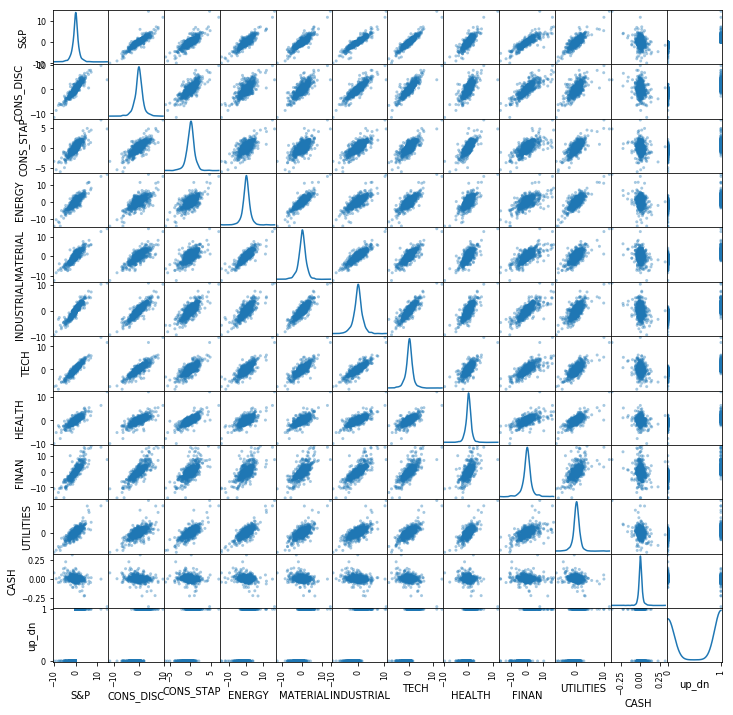

In [50]:
# Screate scatter plot to highlight the high correlation among sector returns
pd.plotting.scatter_matrix(rets_d, diagonal='kde', alpha=0.4, figsize=(12,12))
plt.show()

In [7]:
# Exploratory analysis: create excess returns by subtracting the market return (SPY) from
# the sector returns. 
exc_rets = rets_d.sub(rets_d["S&P"], axis=0)
exc_rets.drop(["S&P", "CASH"], axis=1, inplace=True) # drop S&P and CASH to isolate sector rets

#exc_rets.CASH = rets_d.CASH # Do not create excess returns for CASH
print(exc_rets.head().round(2))

            CONS_DISC  CONS_STAP  ENERGY  MATERIAL  INDUSTRIAL  TECH  HEALTH  \
Date                                                                           
2008-01-02      -0.65      -0.55    1.06     -0.08       -0.78 -1.15   -0.17   
2008-01-03      -1.07      -0.48    1.23      1.86        0.13  0.20    0.65   
2008-01-04      -0.69       2.03   -1.20     -0.57        0.40 -1.45    1.43   
2008-01-07       0.44       1.26   -0.30     -1.29       -1.16 -0.79    2.07   
2008-01-08      -0.32       0.88   -0.13      0.07       -0.61 -1.03    2.43   

            FINAN  UTILITIES  
Date                          
2008-01-02  -1.09       0.31  
2008-01-03  -0.59      -0.09  
2008-01-04  -0.39       3.21  
2008-01-07   0.34       2.16  
2008-01-08  -2.03       1.64  


            CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL      TECH  \
Date                                                                         
2008-01-02  -0.653589  -0.548148  1.064503 -0.083774   -0.784397 -1.150042   
2008-01-03  -1.069725  -0.480062  1.230681  1.864266    0.126195  0.201428   
2008-01-04  -0.690061   2.025718 -1.204258 -0.569570    0.400823 -1.448440   
2008-01-07   0.441605   1.258463 -0.302184 -1.288295   -1.160115 -0.790179   
2008-01-08  -0.323767   0.876707 -0.133860  0.073314   -0.611544 -1.033628   

              HEALTH     FINAN  UTILITIES  
Date                                       
2008-01-02 -0.172406 -1.094812   0.308484  
2008-01-03  0.649333 -0.586402  -0.094265  
2008-01-04  1.426458 -0.388259   3.212011  
2008-01-07  2.068239  0.340587   2.162844  
2008-01-08  2.432215 -2.028143   1.637983  


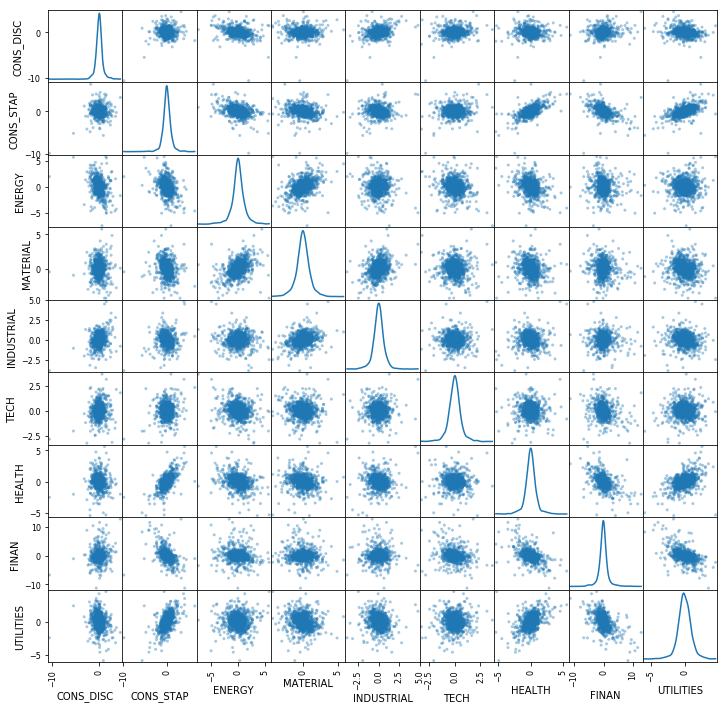

In [8]:
# Plot a scatter matrix of daily excess returns of sectors pairwise. This will reveal if
# any sectors that move together or move inversely
# Drop dataframe columns that have all NAs to avoid graph blowing up.
exc_rets_avail = exc_rets.dropna(axis = 1, how = "all")
print(exc_rets_avail.head())
#
pd.plotting.scatter_matrix(exc_rets_avail, diagonal='kde', alpha=0.4, figsize=(12,12))
plt.show()

In [9]:
# Calculate the correlation of excess returns
# These correlations will be much lower than for returns as we have removed the 
# common element of market returns
exc_rets.corr().round(2)

,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES
CONS_DISC,1.00,0.11,-0.30,-0.02,0.28,0.14,-0.03,0.15,-0.16
CONS_STAP,0.11,1.00,-0.36,-0.22,0.00,0.13,0.64,-0.46,0.56
ENERGY,-0.30,-0.36,1.00,0.42,-0.04,-0.21,-0.32,-0.11,-0.02
MATERIAL,-0.02,-0.22,0.42,1.00,0.30,-0.07,-0.15,-0.07,-0.16
INDUSTRIAL,0.28,0.00,-0.04,0.30,1.00,-0.01,-0.01,-0.01,-0.15
TECH,0.14,0.13,-0.21,-0.07,-0.01,1.00,-0.03,-0.23,0.02
HEALTH,-0.03,0.64,-0.32,-0.15,-0.01,-0.03,1.00,-0.49,0.46
FINAN,0.15,-0.46,-0.11,-0.07,-0.01,-0.23,-0.49,1.00,-0.50
UTILITIES,-0.16,0.56,-0.02,-0.16,-0.15,0.02,0.46,-0.50,1.00


In [10]:
# Forecsting daily returns using a combination of lagged s&p returns and sector excess returns
# y = S&P(t)
# X = [S&P(t-1), CONS_DISC(t-1), ....., REAL_EST(t-1)]
# spy_l is lagged S&P index
spy_l = rets_d[["S&P"]].shift(1)
exc_rets_l = exc_rets.shift(1) # lag exc rets by one pd. for regression

print(rets_d["S&P"].head())
print(spy_l.head())
print(type(spy_l))

print(exc_rets.head())
print(exc_rets_l.head())
print(type(exc_rets_l))

Date
2008-01-02   -0.875461
2008-01-03   -0.048292
2008-01-04   -2.450645
2008-01-07   -0.084919
2008-01-08   -1.614845
Name: S&P, dtype: float64
                 S&P
Date                
2008-01-02       NaN
2008-01-03 -0.875461
2008-01-04 -0.048292
2008-01-07 -2.450645
2008-01-08 -0.084919
<class 'pandas.core.frame.DataFrame'>
            CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL      TECH  \
Date                                                                         
2008-01-02  -0.653589  -0.548148  1.064503 -0.083774   -0.784397 -1.150042   
2008-01-03  -1.069725  -0.480062  1.230681  1.864266    0.126195  0.201428   
2008-01-04  -0.690061   2.025718 -1.204258 -0.569570    0.400823 -1.448440   
2008-01-07   0.441605   1.258463 -0.302184 -1.288295   -1.160115 -0.790179   
2008-01-08  -0.323767   0.876707 -0.133860  0.073314   -0.611544 -1.033628   

              HEALTH     FINAN  UTILITIES  
Date                                       
2008-01-02 -0.172406 -1.094812   0

In [11]:
# Convert market returns into 1 for positive and 0 for negative returns
# Our goal is to classify/predict future market returns into up (1) or down (0)
# which could be used to take positions in the market and make a profit
#
rets_d['up_dn'] = rets_d["S&P"].apply(lambda x: 1 if x > 0 else 0)
rets_d.head().round(3)

,S&P,CONS_DISC,CONS_STAP,ENERGY,MATERIAL,INDUSTRIAL,TECH,HEALTH,FINAN,UTILITIES,CASH,up_dn
Date,,,,,,,,,,,,
2008-01-02,-0.875,-1.529,-1.424,0.189,-0.959,-1.660,-2.026,-1.048,-1.970,-0.567,0.100,0
2008-01-03,-0.048,-1.118,-0.528,1.182,1.816,0.078,0.153,0.601,-0.635,-0.143,-0.046,0
2008-01-04,-2.451,-3.141,-0.425,-3.655,-3.020,-2.050,-3.899,-1.024,-2.839,0.761,0.073,0
2008-01-07,-0.085,0.357,1.174,-0.387,-1.373,-1.245,-0.875,1.983,0.256,2.078,-0.055,0
2008-01-08,-1.615,-1.939,-0.738,-1.749,-1.542,-2.226,-2.648,0.817,-3.643,0.023,0.064,0


In [12]:
# assign independent and depend variables: ydf is dataframe of 1s and 0s
ydf = rets_d[["up_dn"]] # single square brackets turns it into a series

X = spy_l.join(exc_rets_l)
print(ydf.head())
print(X.head())

            up_dn
Date             
2008-01-02      0
2008-01-03      0
2008-01-04      0
2008-01-07      0
2008-01-08      0
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-02       NaN        NaN        NaN       NaN       NaN         NaN   
2008-01-03 -0.875461  -0.653589  -0.548148  1.064503 -0.083774   -0.784397   
2008-01-04 -0.048292  -1.069725  -0.480062  1.230681  1.864266    0.126195   
2008-01-07 -2.450645  -0.690061   2.025718 -1.204258 -0.569570    0.400823   
2008-01-08 -0.084919   0.441605   1.258463 -0.302184 -1.288295   -1.160115   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-02       NaN       NaN       NaN        NaN  
2008-01-03 -1.150042 -0.172406 -1.094812   0.308484  
2008-01-04  0.201428  0.649333 -0.586402  -0.094265  
2008-01-07 -1.448440  1.426458 -0.388259   3.212011  
200

In [13]:
# drop first row of y and X as the X values are NA due to lag of 1
ydf.drop(ydf.index[0], inplace=True)
X.drop(X.index[0], inplace=True)

print(ydf.head())
print(X.head())

            up_dn
Date             
2008-01-03      0
2008-01-04      0
2008-01-07      0
2008-01-08      0
2008-01-09      1
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-03 -0.875461  -0.653589  -0.548148  1.064503 -0.083774   -0.784397   
2008-01-04 -0.048292  -1.069725  -0.480062  1.230681  1.864266    0.126195   
2008-01-07 -2.450645  -0.690061   2.025718 -1.204258 -0.569570    0.400823   
2008-01-08 -0.084919   0.441605   1.258463 -0.302184 -1.288295   -1.160115   
2008-01-09 -1.614845  -0.323767   0.876707 -0.133860  0.073314   -0.611544   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-03 -1.150042 -0.172406 -1.094812   0.308484  
2008-01-04  0.201428  0.649333 -0.586402  -0.094265  
2008-01-07 -1.448440  1.426458 -0.388259   3.212011  
2008-01-08 -0.790179  2.068239  0.340587   2.162844  
200

C:\Users\vchop\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
# Classification models expect the target array to be a list so convert y to a list 
# Otherwise they give a warning
y = ydf["up_dn"].tolist()
#
print(ydf.head())
print(y[:5])
print(X.head())

type(y)

            up_dn
Date             
2008-01-03      0
2008-01-04      0
2008-01-07      0
2008-01-08      0
2008-01-09      1
[0, 0, 0, 0, 1]
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-03 -0.875461  -0.653589  -0.548148  1.064503 -0.083774   -0.784397   
2008-01-04 -0.048292  -1.069725  -0.480062  1.230681  1.864266    0.126195   
2008-01-07 -2.450645  -0.690061   2.025718 -1.204258 -0.569570    0.400823   
2008-01-08 -0.084919   0.441605   1.258463 -0.302184 -1.288295   -1.160115   
2008-01-09 -1.614845  -0.323767   0.876707 -0.133860  0.073314   -0.611544   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-03 -1.150042 -0.172406 -1.094812   0.308484  
2008-01-04  0.201428  0.649333 -0.586402  -0.094265  
2008-01-07 -1.448440  1.426458 -0.388259   3.212011  
2008-01-08 -0.790179  2.068239  0.340587 

list

In [15]:
# For linear regn, we will let y be an ordinal variable, yvar, i.e. not convert it to binary
# up/down indicator 1/0.
# Drop the first row of y to align with X
yvar = rets_d["S&P"][1:].copy()
print(yvar.head())
print(X.head())

Date
2008-01-03   -0.048292
2008-01-04   -2.450645
2008-01-07   -0.084919
2008-01-08   -1.614845
2008-01-09    1.051033
Name: S&P, dtype: float64
                 S&P  CONS_DISC  CONS_STAP    ENERGY  MATERIAL  INDUSTRIAL  \
Date                                                                         
2008-01-03 -0.875461  -0.653589  -0.548148  1.064503 -0.083774   -0.784397   
2008-01-04 -0.048292  -1.069725  -0.480062  1.230681  1.864266    0.126195   
2008-01-07 -2.450645  -0.690061   2.025718 -1.204258 -0.569570    0.400823   
2008-01-08 -0.084919   0.441605   1.258463 -0.302184 -1.288295   -1.160115   
2008-01-09 -1.614845  -0.323767   0.876707 -0.133860  0.073314   -0.611544   

                TECH    HEALTH     FINAN  UTILITIES  
Date                                                 
2008-01-03 -1.150042 -0.172406 -1.094812   0.308484  
2008-01-04  0.201428  0.649333 -0.586402  -0.094265  
2008-01-07 -1.448440  1.426458 -0.388259   3.212011  
2008-01-08 -0.790179  2.068239  0.340

In [16]:
# To evaluate models we split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# The second split is for linreg model as we are using continuous yvar as the dependent variable
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, yvar, test_size=0.3, random_state=0)

In [17]:
# from sklearn import linear_model
# X is already defined above
# For linear regn, we will let y be an ordinal variable, i.e. we will not convert it to up/dn
# We run the model without an intercept as we do not expect a constant
# Fit the linear model
linreg = linear_model.LinearRegression(fit_intercept=False)
# Fit the model over the training period, and evaluate it in-sample as well as over a test sample
linreg.fit(X_train_lr, y_train_lr)
print("Accuracy of LinReg on training set: {:.3f}".format(linreg.score(X_train_lr, y_train_lr)))
print("Accuracy of LinReg on test set: {:.3f}".format(linreg.score(X_test_lr, y_test_lr)))

Accuracy of LinReg on training set: 0.031
Accuracy of LinReg on test set: 0.027


In [18]:
print(X.shape)
len(y)

(1258, 10)


1258

In [19]:
# Set up logistic regression and print parameters
#
lm = LogisticRegression(fit_intercept=False)
lm.fit(X_train, y_train)

print(lm.coef_.round(3))
print(lm.intercept_)
print(np.mean(y).round(3))

[[ 0.096  0.149  0.142 -0.081  0.037 -0.002 -0.024  0.002 -0.019  0.123]]
0.0
0.547


In [20]:
# predict class labels for the test set
predicted = lm.predict(X_test)
print(predicted)

[1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1
 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1
 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0
 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1
 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1
 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0
 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1
 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1
 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 1 0 0
 0 0 1 0 0 0 1 0]


In [21]:
# generate class probabilities
probs = lm.predict_proba(X_test)
print(probs[:5])

[[ 0.4901464   0.5098536 ]
 [ 0.54419261  0.45580739]
 [ 0.59631622  0.40368378]
 [ 0.53404807  0.46595193]
 [ 0.46112441  0.53887559]]


In [22]:
# generate evaluation metrics
print(metrics.accuracy_score(y_test, predicted))
print(metrics.roc_auc_score(y_test, probs[:, 1]))

0.510582010582
0.499857533622


In [23]:
# Confusion matrix and classification report
#
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[ 79  85]
 [100 114]]
             precision    recall  f1-score   support

          0       0.44      0.48      0.46       164
          1       0.57      0.53      0.55       214

avg / total       0.52      0.51      0.51       378



In [24]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.57936508  0.49206349  0.50793651  0.57936508  0.57936508  0.54761905
  0.53968254  0.56349206  0.528       0.552     ]
0.546888888889


In [25]:
# Classification using K-Nearest Neighbors
# n_neighbors is our option in KNN. We'll tune this value to attempt to improve our prediction.
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
#print(knn.predict(X))
#print(y)

print("Accuracy of KNN on training set: {:.3f}".format(knn.score(X_train, y_train)))
print("Accuracy of KNN on test set: {:.3f}".format(knn.score(X_test, y_test)))

Accuracy of KNN on training set: 0.686
Accuracy of KNN on test set: 0.532


In [33]:
# Set up a decision tree classifier
dec_tree = DecisionTreeClassifier(max_depth=2)

# Fits the model
dec_tree.fit(X_train, y_train)

print("Accuracry on training set: {:.3f}".format(dec_tree.score(X_train, y_train)))

print("Accuracy on test set: {:.3f}".format(dec_tree.score(X_test, y_test)))

Accuracry on training set: 0.564
Accuracy on test set: 0.563


In [34]:
dec_tree.feature_importances_

array([ 0.3791909 ,  0.        ,  0.46393152,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.15687758])

In [35]:
# Optional: Helper function to visualize Decision Trees (creates a file tree.png)

from sklearn.tree import export_graphviz
from os import system 
def build_tree_image(dec_tree):
    dotfile = open("tree.dot", 'w')
    export_graphviz(dec_tree,
                              out_file = dotfile,
                              feature_names = X.columns)
    dotfile.close()
    system("dot -Tpng tree.dot -o tree.png")

build_tree_image(dec_tree) # creates tree.png tree

In [37]:
# Random forest classifier
rforest = RandomForestClassifier(n_estimators = 1, max_depth = 2)
rforest.fit(X_train, y_train)

print("Accuracy of RF on training set: {:.3f}".format(rforest.score(X_train, y_train)))
print("Accuracy of RF on test set: {:.3f}".format(rforest.score(X_test, y_test)))

Accuracy of RF on training set: 0.566
Accuracy of RF on test set: 0.574


In [44]:
# Boosting model
adaboost = AdaBoostClassifier(n_estimators=7)
adaboost.fit(X_train, y_train)
print("Accuracy of AB on training set: {:.3f}".format(adaboost.score(X_train, y_train)))
print("Accuracy of AB on test set: {:.3f}".format(adaboost.score(X_test, y_test)))

Accuracy of AB on training set: 0.588
Accuracy of AB on test set: 0.532


In [48]:
# Bagging algorithm
bclass = BaggingClassifier(n_estimators=2, max_features=10)
bclass.fit(X_train, y_train)
print("Accuracy of Bagg on training set: {:.3f}".format(bclass.score(X_train, y_train)))
print("Accuracy of Bagg on test set: {:.3f}".format(bclass.score(X_test, y_test)))

Accuracy of Bagg on training set: 0.815
Accuracy of Bagg on test set: 0.489
